In [92]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

In [93]:
# extract instance data
col_names_instance =['instance', 'number_of_movements', 'number_of_vessels', 'average_headway',
                                        'std_dev_headway', 'spread', 'average_time_between_movements',
                                        'average_travel_time']
data_instance = pd.read_excel('results/instance_data.xlsx', names=col_names_instance, header=0)


In [94]:
# data extraction
col_names = ['instance', 'number of movements', 'median_delay', 'average_delay', 'epochs', 'obj_val',
                               'neighborhood_size', 't0', 'alpha', 'neighbor_deviation_scale', 'affected_movements',
                               'time_interval', 'vessel_time_window']

data1 = pd.read_excel('results/SA/output_40x100_T0xAlpha.xlsx', names=col_names, header=0)
data2 = pd.read_excel('results/SA/output_40x100_T0xAlpha_continued.xlsx', names=col_names, header=0)
data3 = pd.read_excel('results/SA/output_40x100_T0xAlpha_continued_1.xlsx', names=col_names, header=0)
data = pd.concat([data1, data2, data3])

data = data.dropna()


In [95]:
# merge data
# add the data of each instance to each row corresponding to the instance
data = pd.merge(data, data_instance, on='instance')
print(data.head())

   instance  number of movements  median_delay  average_delay  epochs  \
0         1                 20.0      1.083333       1.095833     200   
1         1                 20.0      0.916667       0.945833     200   
2         1                 20.0      0.833333       1.170833     200   
3         1                 20.0      0.250000       0.391667     200   
4         1                 20.0      0.541667       0.825000     200   

      obj_val  neighborhood_size   t0     alpha  neighbor_deviation_scale  \
0  109.583333                  6  260  0.952648                        40   
1   94.583333                  6  269  0.852249                        40   
2  117.083333                  6  380  0.928626                        40   
3   39.166667                  6  454  0.656679                        40   
4   82.500000                  6  167  0.884286                        40   

   affected_movements  time_interval  vessel_time_window  number_of_movements  \
0                

In [96]:
feature_cols = ['t0', 'alpha', # info about the algorithm
                'number_of_movements', 'number_of_vessels', 'average_headway', 'std_dev_headway', 'spread', # info about the instance
                'average_time_between_movements', 'average_travel_time']
X = data[feature_cols]
y = data.average_delay

# if the delay is nan, it means that the algorithm did not find a solution
# give it a delay of 10
# y = y.fillna(10)

C:\Users\ilias\AppData\Local\Temp\ipykernel_16656\113397303.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y, shade=True)


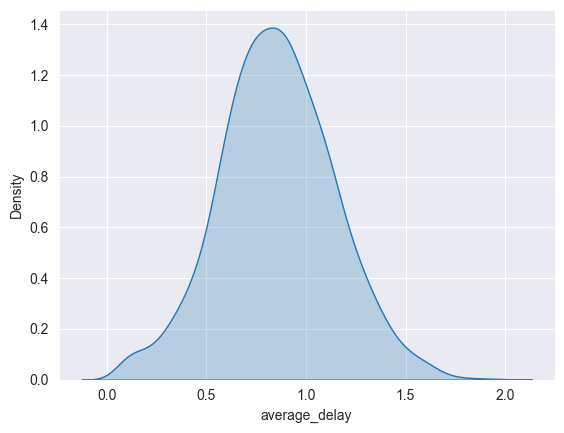

In [97]:
# split the delay into 3 classes
# make a curve to see the distribution of the delay
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(y, shade=True)
plt.show()

In [98]:
# split the delay into 3 classes by quantiles
# y = pd.qcut(y, 4, labels=False)

In [99]:
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [101]:
## perform exhaustive grid search to find the best parameters
#from sklearn.model_selection import GridSearchCV
## Create the parameter grid based on the results of random search
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [6, 7,8, 9,10],
#    'max_features': [2, 3, 4],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [8, 10, 12],
#    'n_estimators': [100, 200]
#}
## Create a based model
#rf = RandomForestRegressor()
## Instantiate the grid search model
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
#                           cv=3, n_jobs=-1, verbose=2)
## Fit the grid search to the data
#grid_search.fit(X_train, y_train)

In [102]:
# print the best parameters
print(grid_search.best_params_)

# print the best estimator
print(grid_search.best_estimator_)


{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 200}
RandomForestRegressor(max_depth=10, max_features=2, min_samples_leaf=4,
                      min_samples_split=12, n_estimators=200)


In [120]:
regr = RandomForestRegressor(max_depth=7, max_features=2, min_samples_leaf=4,
                      min_samples_split=12, n_estimators=200)

# adapt so predicting low delay is a good prediction
regr = RandomForestRegressor(max_depth=7, max_features=2, min_samples_leaf=4,
                      min_samples_split=12, n_estimators=200, criterion='absolute_error')


regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# test the accuracy for the regression
print("Accuracy:", metrics.r2_score(y_test, y_pred))
# predict other metrics for the regression
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, y_pred))



Accuracy: 0.2331196619411069
Mean Absolute Error: 0.1881602377766445
Mean Squared Error: 0.057767362716503706


In [122]:
# return the feature values for wich the prediction is lower than 0.5
# this means a good prediction
# print the feature values and the prediction
print("Feature values for wich the prediction is lower than 0.5")
print(X_test[y_pred < 0.5])

# save this in a dataframe
df = pd.DataFrame(X_test[y_pred < 0.5])
# save as a list of lists
df.to_csv('results/SA/feature_values_good_prediction.csv', index=False, header=False)


Feature values for wich the prediction is lower than 0.5
       t0     alpha  number_of_movements  number_of_vessels  average_headway  \
1343  261  0.816654                   21                 19         0.381436   
1326   79  0.787729                   21                 19         0.381436   
1347  300  0.868521                   21                 19         0.381436   
2588  296  0.605074                   25                 22         0.412585   
1341  159  0.820495                   21                 19         0.381436   

      std_dev_headway     spread  average_time_between_movements  \
1343         0.527108  16.166667                        0.769841   
1326         0.527108  16.166667                        0.769841   
1347         0.527108  16.166667                        0.769841   
2588         0.568948  35.583333                        1.423333   
1341         0.527108  16.166667                        0.769841   

      average_travel_time  
1343             2.162698

In [115]:
# save the model
import pickle
filename = 'results/SA/models/RandomForestRegressor.sav'
pickle.dump(regr, open(filename, 'wb'))

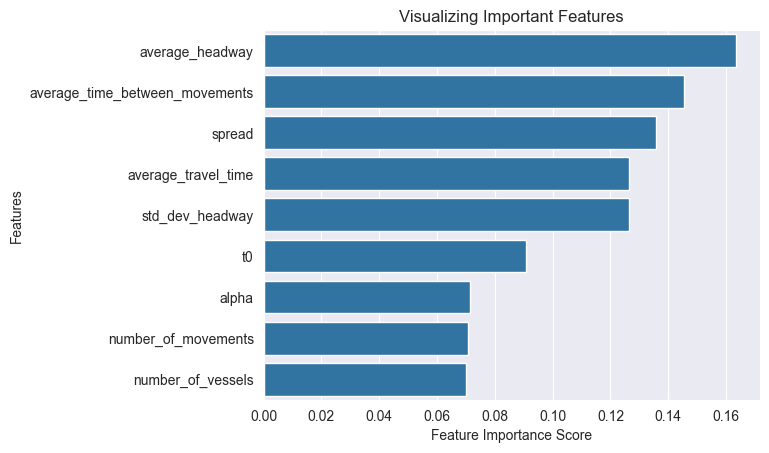

In [116]:
# create a graph of the feature importance
feature_imp = pd.Series(regr.feature_importances_, index=feature_cols).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

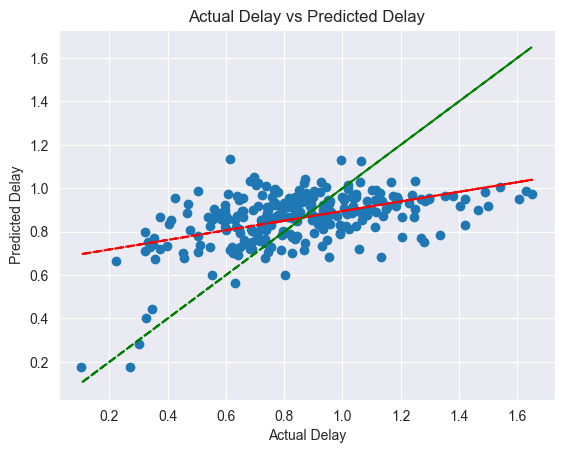

In [117]:

# graph the predicted delay vs the actual delay
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Delay')
plt.ylabel('Predicted Delay')
plt.title("Actual Delay vs Predicted Delay")
# plot the line of best fit
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"r--")
# plot the line y=x
plt.plot(y_test, y_test, 'g--')
plt.show()


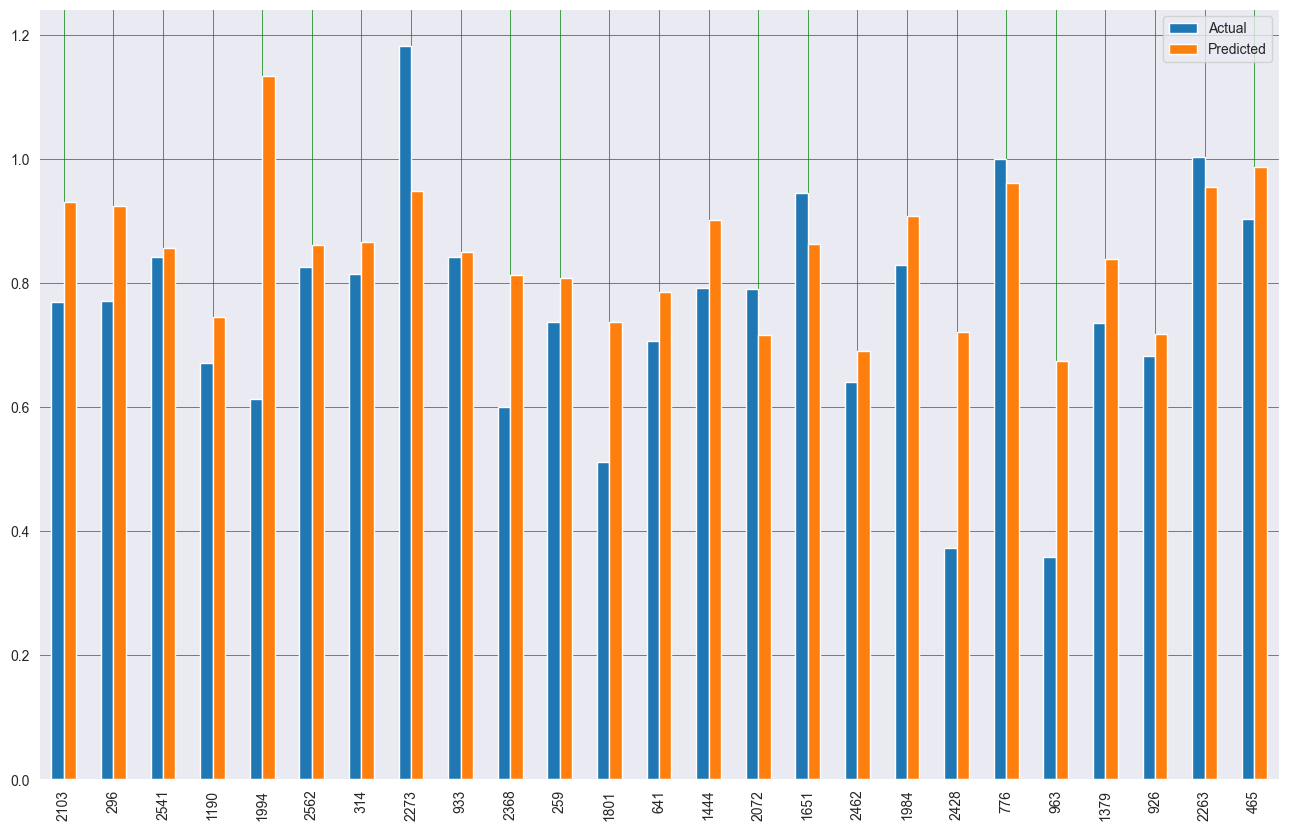

In [118]:
# create a graph of the predicted delay vs the actual delay
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1.plot(kind='bar', figsize=(16, 10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()